In [1]:
import pandas as pd
import numpy as np
import yaml

data_path = yaml.full_load(open('../config.yaml'))['data_path']

from matplotlib import pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['font.size'] = 15

In [3]:
def visualize_labels(df, task):
    df['{}_ONSET_HOUR'.format(task)].plot.hist(bins=np.arange(-5, 75, 0.5), alpha=0.9)
    plt.xlim(-4,100)
    plt.xlabel('{} onset hour'.format(task))
    plt.savefig('fig/Onset_{}-histogram.png'.format(task), dpi=300)
    plt.show()

In [4]:
df_ARF   = pd.read_csv(data_path + 'labels/ARF.csv',   index_col='ICUSTAY_ID')
df_Shock = pd.read_csv(data_path + 'labels/Shock.csv', index_col='ICUSTAY_ID')

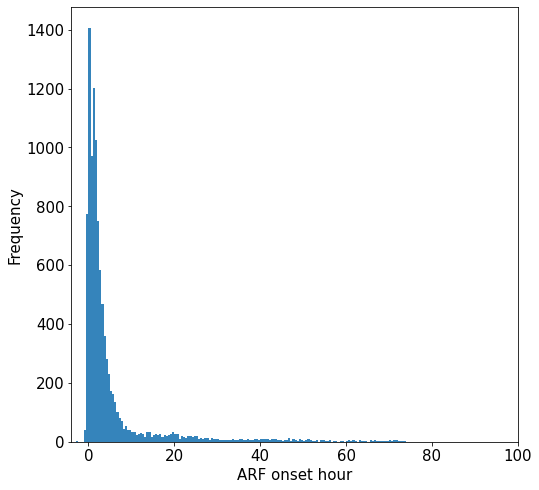

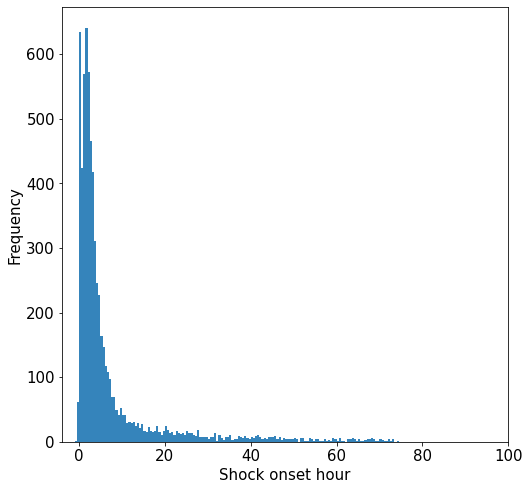

In [5]:
visualize_labels(df_ARF, 'ARF')
visualize_labels(df_Shock, 'Shock')

---

In [6]:
from datetime import timedelta
cutoff_h = 4
mimic3_path = yaml.full_load(open('../config.yaml'))['mimic3_path']

In [7]:
patients = pd.read_csv(mimic3_path + 'PATIENTS.csv', parse_dates=['DOB', 'DOD'], usecols=['SUBJECT_ID', 'DOB', 'DOD'])
admissions = pd.read_csv(mimic3_path + 'ADMISSIONS.csv', parse_dates=['DEATHTIME'], usecols=['SUBJECT_ID', 'HADM_ID', 'DEATHTIME'])
examples = pd.read_csv(data_path + 'prep/icustays_MV.csv', parse_dates=['INTIME', 'OUTTIME']).sort_values(by='ICUSTAY_ID') # Only Metavision

examples = pd.merge(examples, patients, on='SUBJECT_ID', how='left')
examples = pd.merge(examples, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='left')
examples['AGE'] = examples.apply(lambda x: (x['INTIME'].to_pydatetime() - x['DOB'].to_pydatetime()).total_seconds(), axis=1) / 3600 / 24 / 365.25

examples['LOS'] = examples['LOS'] * 24 # Convert to hours

In [8]:
(examples[['LOS']] / 24.).describe()

,LOS
count,23620.000000
mean,3.593499
std,4.971162
min,0.000400
25%,1.151600
50%,1.996050
75%,3.835000
max,101.739000


In [9]:
# Remove non-adults
min_age = 18
max_age = np.inf # no max age
examples = examples[(examples.AGE >= min_age) & (examples.AGE <= max_age)]

In [10]:
examples['ICUSTAY_ID'].nunique()

23593

In [11]:
examples[['ICUSTAY_ID', 'DEATHTIME', 'INTIME']].iloc[10:]

,ICUSTAY_ID,DEATHTIME,INTIME
10,200038,NaT,2143-10-24 20:35:24
11,200040,NaT,2153-10-24 16:01:41
12,200049,NaT,2118-08-28 08:56:44
13,200050,NaT,2149-07-14 17:51:18
14,200053,NaT,2166-02-27 18:45:49
...,...,...,...
23615,299956,NaT,2177-05-29 07:38:54
23616,299957,NaT,2132-10-13 10:41:17
23617,299962,NaT,2195-11-25 19:04:06
23618,299979,NaT,2127-12-05 02:16:42


In [12]:
# Death time < intime
sum((examples['DEATHTIME'] - examples['INTIME']).dt.total_seconds() < 0)

27

In [13]:
# LOS vs OUTTIME - INTIME
((examples['OUTTIME'] - examples['INTIME']).dt.total_seconds() / 3600 - examples['LOS']).describe()

count    2.359300e+04
mean    -7.175857e-06
std      6.949819e-04
min     -1.200000e-03
25%     -6.111111e-04
50%     -7.105427e-15
75%      5.888889e-04
max      1.188889e-03
dtype: float64

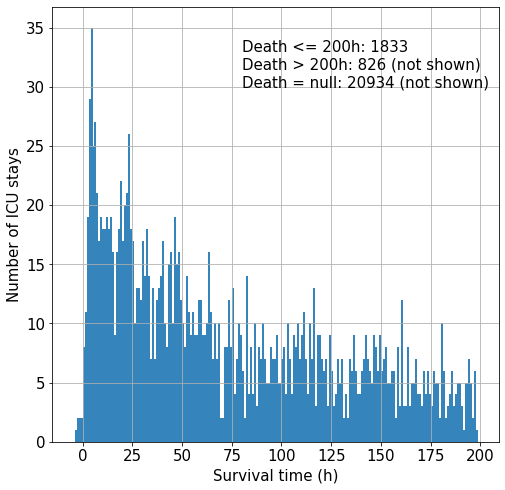

In [14]:
((examples['DEATHTIME'] - examples['INTIME']).dt.total_seconds() / 3600).hist(bins=np.arange(-5, 200, 1), alpha=0.9)
plt.xlabel('Survival time (h)')
plt.ylabel('Number of ICU stays')
plt.text(80, 30, 'Death <= 200h: {}\nDeath > 200h: {} (not shown) \nDeath = null: {} (not shown)' \
         .format(sum(((examples['DEATHTIME'] - examples['INTIME']).dt.total_seconds() / 3600) <= 200), 
                 sum(((examples['DEATHTIME'] - examples['INTIME']).dt.total_seconds() / 3600) > 200),
                sum(examples['DEATHTIME'].isnull())))
plt.show()

In [15]:
examples['ICUSTAY_ID'].nunique()

23593

In [16]:
sum((examples['LOS']) <= 200), sum((examples['LOS']) > 200)

(21439, 2154)

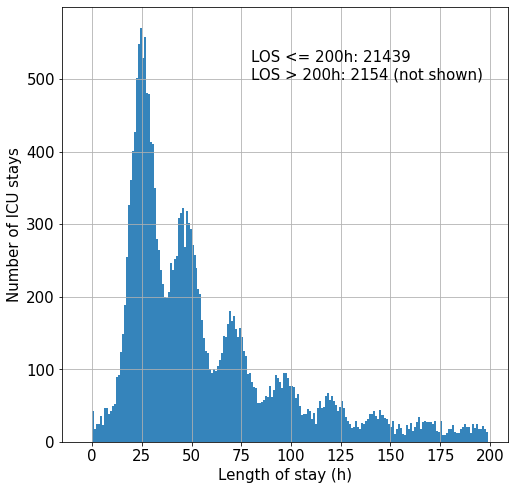

In [17]:
(examples['LOS']).hist(bins=np.arange(-5, 200, 1), alpha=0.9)
plt.xlabel('Length of stay (h)')
plt.ylabel('Number of ICU stays')
plt.text(80, 500, 'LOS <= 200h: {}\nLOS > 200h: {} (not shown)'.format(sum((examples['LOS']) <= 200), sum((examples['LOS']) > 200)))
plt.show()

In [18]:
# Remove died before cutoff hour
examples = examples[(examples.DEATHTIME >= examples.INTIME + timedelta(hours=cutoff_h)) | (examples.DEATHTIME.isnull())]

In [19]:
# Remove LOS < cutoff hour
examples = examples[examples['LOS'] >= cutoff_h]